# 2020 US General Election

---

---

---

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from statsmodels.stats.weightstats import DescrStatsW

import us

import sys

import os
path = os.getcwd()
path = path[:path.find('us_election2020')] + 'us_election2020'

sys.path.append(path + '\\src\\data')
import make_dataset

In [44]:
make_dataset.general_election_polls2020_preprocessig()

In [45]:
make_dataset.president_approval_polls2020_preprocessig()

In [46]:
polls2020 = pd.read_csv(path + '\data\processed\general_election_polls2020.csv', 
                        parse_dates=['start_date', 'end_date', 'created_at'], index_col=['start_date'])

In [47]:
polls2020

,poll_id,question_id,state,pollster_id,pollster,sample_size,population,end_date,created_at,url,Trump,Biden,diff,population_weight,weight
start_date,,,,,,,,,,,,,,,
2018-11-27,57026,92080,Ohio,383,Public Policy Polling,648,v,2018-11-28,2018-12-06 14:43:00,https://www.cleveland.com/politics/2018/11/thi...,44.00,48.00,4.00,0.8,518.4
2018-12-16,57170,92351,National,1416,Harris Insights & Analytics,1001,rv,2018-12-17,2018-12-25 23:57:00,https://thehill.com/hilltv/what-americas-think...,36.00,42.00,6.00,0.9,900.9
2019-01-04,57275,92597,North Carolina,383,Public Policy Polling,750,rv,2019-01-07,2019-01-09 13:09:00,https://www.publicpolicypolling.com/wp-content...,44.00,49.00,5.00,0.9,675.0
2019-01-19,57365,92773,National,383,Public Policy Polling,760,rv,2019-01-21,2019-01-22 13:58:00,https://www.publicpolicypolling.com/wp-content...,41.00,53.00,12.00,0.9,684.0
2019-01-24,57427,92926,Michigan,176,Glengariff Group,600,lv,2019-01-26,2019-01-29 21:17:00,https://www.clickondetroit.com/michigan-politi...,40.30,53.30,13.00,1.0,600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-23,68214,127766,National,568,YouGov,1256,rv,2020-08-25,2020-08-26 10:14:00,https://docs.cdn.yougov.com/csnify0kol/weeklyt...,41.00,50.00,9.00,0.9,1130.4
2020-08-25,68237,127825,National,1562,Redfield & Wilton Strategies,1834,lv,2020-08-26,2020-08-28 10:08:00,https://redfieldandwiltonstrategies.com/latest...,38.83,48.85,10.02,1.0,1834.0
2020-08-25,68240,127831,Massachusetts,1102,Emerson College,763,lv,2020-08-27,2020-08-28 16:00:00,https://emersonpolling.reportablenews.com/pr/m...,30.56,69.44,38.88,1.0,763.0


---

---

---

In [48]:
def get_state_statsSmooth_atK(df, candidates, state, k):
    """
    Get candidate's average and standard deviation (weighted) in state
    INPUT:
    - df: dataframe with polls statistics
    - candidates: list of candidates to return stats
    - state: US state
    - k: last k polls to analyse
    
    OUTPUT:
    - df with candidates avg, diff avd, and std
    """
    
    candidates = candidates + ['diff']
    cols_avg = [c + '_avg' for c in candidates]
    cols_std = [c + '_std' for c in candidates]
    cols_wgt = ['weight_'+ c for c in candidates]

    df = df[df['state'] == state]
    df = df[candidates + ['pollster_id', 'weight']]

    start = str(df.index.min().date())
    end = str(datetime.today().date())

    index_stats_df = pd.date_range(start=start, end=end, freq='D')
    cols_stats_df = cols_avg + cols_std
    
    state_stats_df = pd.DataFrame(index=index_stats_df, columns=cols_stats_df)
    
    df['weight'] = (df[['weight']])**(1/4)
    
    day0 = index_stats_df[0]
    atK_df = df.loc[:day0].tail(k)
    atK_pollsTimes = atK_df.groupby('pollster_id').count()[['weight']].rename(columns={'weight':'times'}).reset_index()
    atK_df = atK_df.merge(atK_pollsTimes, on='pollster_id')
    atK_df['weight'] = atK_df['weight']/(atK_df['times'])
    
    state_stats_df.loc[day0, cols_avg] = atK_df[candidates].values[0]
    state_stats_df.loc[day0, cols_std] = np.nan
    
    for day in index_stats_df[1:]:
        atK_df = df.loc[:day].tail(k)
        
        atK_pollsTimes = atK_df.groupby('pollster_id').count()[['weight']].rename(columns={'weight':'times'}).reset_index()
        atK_df = atK_df.merge(atK_pollsTimes, on='pollster_id')
        atK_df['weight'] = atK_df['weight']/(atK_df['times'])
            
        for col in cols_wgt:
            atK_df[col] = atK_df['weight']
            
        r_dispersion = ((np.abs((atK_df[candidates] - state_stats_df[cols_avg].dropna().iloc[-1].values)) + 1).values**(2))
        atK_df[cols_wgt] /= r_dispersion
    
        for i in range(3):
            weighted_stats = DescrStatsW(atK_df[candidates[i]], weights=atK_df[cols_wgt[i]], ddof=0)
            state_stats_df.loc[day, [cols_avg[i]]] = weighted_stats.mean.reshape(-1,)
            state_stats_df.loc[day, [cols_std[i]]] = weighted_stats.std.reshape(-1,)

    state_stats_df = state_stats_df.dropna(axis='rows', how='all').astype(float)
    
    if state == 'National':
        round(state_stats_df, 4).to_csv(path+'\\data\\processed\\National_stats_at'+str(k)+'.csv')
    return round(state_stats_df, 4)

In [49]:
def get_Allstates_statsSmooth_atK(df, candidates=['Biden', 'Trump'], k=16):
    
    df = df.loc['2020-01-01':]
    
    Allstate_stats_df = pd.DataFrame()
    for state in sorted(df['state'].unique()):
        print(state, end='                    \r')
        state_stats_df = get_state_statsSmooth_atK(df, candidates, state, k)
        state_stats_df['state'] = state
        Allstate_stats_df = Allstate_stats_df.append(state_stats_df)
        
    round(Allstate_stats_df, 4).to_csv(path+'\\data\\processed\\AllStates_stats_k'+str(k)+'.csv')
    return round(Allstate_stats_df, 4)

In [50]:
national_statsSmooth_k = get_state_statsSmooth_atK(polls2020, candidates=['Biden', 'Trump'], state='National', k=8)
national_statsSmooth_2k = get_state_statsSmooth_atK(polls2020, candidates=['Biden', 'Trump'], state='National', k=16)

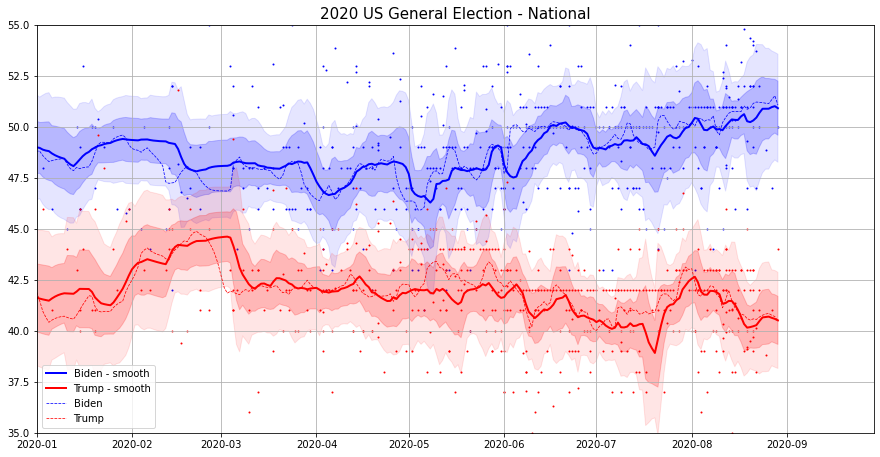

In [51]:
plt.figure(figsize=(15, 7.5))

plt.plot(national_statsSmooth_2k[['Biden_avg']], lw=2., label='Biden - smooth', color='blue')
plt.plot(national_statsSmooth_2k[['Trump_avg']], lw=2., label='Trump - smooth', color='red')

plt.plot(national_statsSmooth_k[['Biden_avg']], lw=0.75, ls='--', label='Biden', color='blue')
plt.plot(national_statsSmooth_k[['Trump_avg']], lw=0.75, ls='--', label='Trump', color='red')


candidates_color = {'Biden':'blue', 'Trump':'red'}
for candidate in ['Biden', 'Trump']:
    plt.scatter(polls2020.loc[polls2020['state']=='National'].index, 
                polls2020.loc[polls2020['state']=='National'][candidate], color=candidates_color[candidate], s=1.)
    plt.fill_between(national_statsSmooth_2k[candidate+'_avg'].index,
                     national_statsSmooth_2k[candidate+'_avg']+2*national_statsSmooth_2k[candidate+'_std'],
                     national_statsSmooth_2k[candidate+'_avg']-2*national_statsSmooth_2k[candidate+'_std'],
                     alpha=0.1, color=candidates_color[candidate])
    plt.fill_between(national_statsSmooth_2k[candidate+'_avg'].index,
                     national_statsSmooth_2k[candidate+'_avg']+national_statsSmooth_2k[candidate+'_std'],
                     national_statsSmooth_2k[candidate+'_avg']-national_statsSmooth_2k[candidate+'_std'],
                     alpha=0.2, color=candidates_color[candidate])

plt.title('2020 US General Election - National', fontsize=15)
plt.legend()
plt.grid()
plt.xlim(xmin=pd.to_datetime('2020-01-01'))
plt.ylim(35, 55)
plt.show()


In [52]:
def get_table_atK(df, state, k, election=2020):
    """
    Get table with last k polls in the state with sample size and type of respondents (population)
    INPUT:
    - df: dataframe with polls statistics
    - candidates: list of candidates to return stats
    - state: US state
    - k: last k polls to analyse
    
    OUTPUT:
    - df with candidates avg, diff avd, and std
    """
    
    df = df[df['state'] == state]
    df = df.reset_index()
    df = df.reset_index().set_index(['start_date', 'end_date', 'pollster', 'population', 'sample_size'])
    if election == 2020:
        candidates = ['Biden', 'Trump']
    elif election == 2016:
        candidates = ['Clinton', 'Trump']
    df = df[candidates].tail(k).sort_index(level=['start_date', 'end_date'], ascending=[False, False])
    
    return df

In [53]:
def get_polls_plot_atK(df, state, k, election=2020):
    """
    Plot graphs
    INPUT:
    - df: dataframe with polls statistics
    - state: US state
    - k: last k polls to analyse
    - election: 2016, 2020, or pr_approval
    
    OUTPUT:
    - plot
    """
    if election == 'pr_approval':
        candidates = ['approve', 'disapprove']
        candidates_color = {'approve':'darkorange', 'disapprove':'darkgreen'}
    if election == 2020:
        candidates = ['Biden', 'Trump']
        candidates_color = {'Biden':'blue', 'Trump':'red'}
    elif election == 2016:
        candidates = ['Clinton', 'Trump']
        candidates_color = {'Clinton':'blue', 'Trump':'red'}
    
    state_polls2020 = df[df['state'] == state]
    if state == 'National' and election == 2020:
        state_stats_k = pd.read_csv(path+'\\data\\processed\\National_stats_at'+str(k)+'.csv', parse_dates=True, index_col=0)
        state_stats_kHalf = pd.read_csv(path+'\\data\\processed\\National_stats_at'+str(int(k/2))+'.csv', parse_dates=True, index_col=0)
    else:
        state_stats_k = get_state_statsSmooth_atK(df, candidates, state, k)
        state_stats_kHalf = get_state_statsSmooth_atK(df, candidates, state, int(k/2))

    plt.figure(figsize=(15, 7.5))
    
    for candidate in candidates:
        plt.scatter(state_polls2020.index, state_polls2020[candidate], color=candidates_color[candidate], s=2.5)
        plt.plot(state_stats_k[candidate+'_avg'], color=candidates_color[candidate], lw=1.5, label=candidate+' - k='+str(k))
        plt.plot(state_stats_kHalf[candidate+'_avg'], color=candidates_color[candidate], lw=1, alpha=0.75, ls='--', label=candidate+' - k='+str(int(k/2)))
        
        plt.text(x=state_stats_k[candidate+'_avg'].index[-1] + timedelta(days=2.5),
                 y=state_stats_k[candidate+'_avg'].iloc[-1], fontsize=12.5,
                 s=str(round(state_stats_k[candidate+'_avg'].iloc[-1], 1)), color=candidates_color[candidate])


        plt.fill_between(state_stats_k[candidate+'_avg'].index,
                         state_stats_k[candidate+'_avg']+2*state_stats_k[candidate+'_std'],
                         state_stats_k[candidate+'_avg']-2*state_stats_k[candidate+'_std'],
                         alpha=0.1, color=candidates_color[candidate])
        plt.fill_between(state_stats_k[candidate+'_avg'].index,
                         state_stats_k[candidate+'_avg']+state_stats_k[candidate+'_std'],
                         state_stats_k[candidate+'_avg']-state_stats_k[candidate+'_std'],
                         alpha=0.2, color=candidates_color[candidate])

    plt.legend()
    if election == 'pr_approval': 
        plt.xlim(xmin=datetime(2019, 1, 1), xmax=state_polls2020.index.max() + timedelta(days=21))
        plt.ylim((30, 65))
        plt.title('2020 US General Election - Trump Job Approval', fontsize=15)
        plt.grid(ls='--', alpha=0.5)
        plt.tight_layout()
        plt.savefig(path+'\\reports\\figures\\2020_US_Genereal_Election-TrumpJobApproval.png')
    else: 
        plt.xlim(xmin=datetime(2020, 1, 1), xmax=state_polls2020.index.max() + timedelta(days=21))
        plt.ylim((35, 55))
        plt.title('2020 US General Election - '+state, fontsize=15)
        plt.grid(ls='--', alpha=0.5)
        plt.tight_layout()
        plt.savefig(path+'\\reports\\figures\\2020_US_Genereal_Election-'+state+'-polls.png')

    plt.show()

---

---

---

# National Report

## 1. who leads the National preference to be the US next president?

---

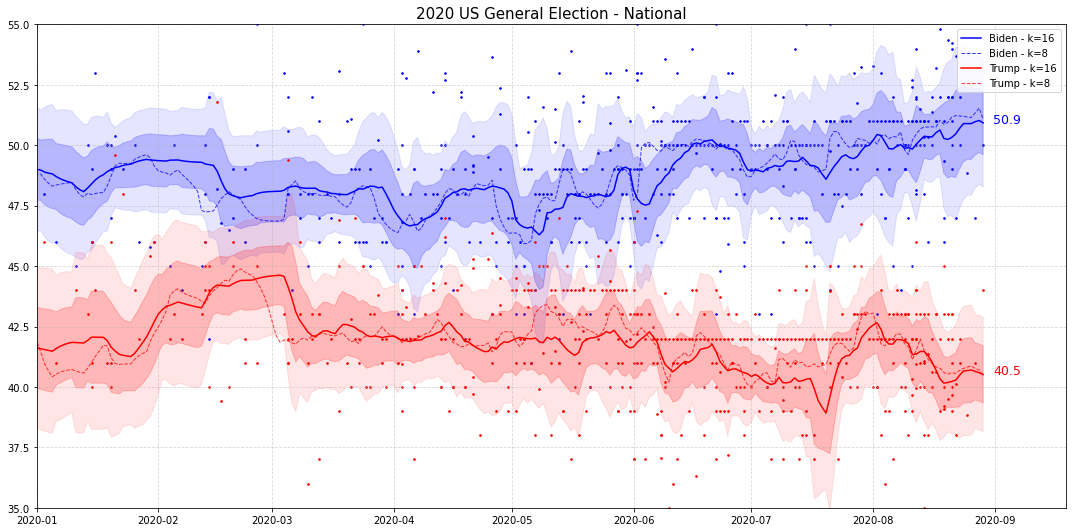

Biden  \
start_date end_date   pollster                                      population sample_size          
2020-08-29 2020-08-29 Morning Consult                               lv         4035         50.00   
2020-08-27 2020-08-28 YouGov                                        rv         807          47.00   
2020-08-25 2020-08-26 Redfield & Wilton Strategies                  lv         1834         48.85   
2020-08-23 2020-08-25 YouGov                                        rv         1256         50.00   
           2020-08-23 Morning Consult                               lv         4810         52.00   
2020-08-22 2020-08-28 USC Dornsife/Los Angeles Times                lv         2568         53.71   
           2020-08-25 Harris Insights & Analytics                   rv         2861         47.00   
2020-08-21 2020-08-27 USC Dornsife/Los Angeles Times                lv         2544         54.24   
           2020-08-24 Global Strategy Group/GBAO/Navigator Research rv         1319         54.00   
           2020-08-23 Change Research                               lv         2362         51.00   

                                                                                            Trump  
start_date end_date   pollster                                      population sample_size         
2020-08-29 2020-08-29 Morning Consult                               lv         4035         44.00  
2020-08-27 2020-08-28 YouGov                                        rv         807          41.00  
2020-08-25 2020-08-26 Redfield & Wilton Strategies                  lv         1834         38.83  
2020-08-23 2020-08-25 YouGov                                        rv         1256         41.00  
           2020-08-23 Morning Consult                               lv         4810         42.00  
2020-08-22 2020-08-28 USC Dornsife/Los Angeles Times                lv         2568         40.14  
           2020-08-25 Harris Insights & Analytics                   rv         2861         38.00  
2020-08-21 2020-08-27 USC Dornsife/Los Angeles Times                lv         2544         39.68  
           2020-08-24 Global Strategy Group/GBAO/Navigator Research rv         1319         41.00  
           2020-08-23 Change Research                               lv         2362         43.00

In [54]:
get_polls_plot_atK(polls2020, 'National', 16, election=2020)
get_table_atK(polls2020, 'National', k=10)

In [55]:
def get_states_diff_distribution(df, k, election=2020, on_day=str(datetime.today().date())):
    """
    Get difference distribution between candidates (Democrat - Republican) per state
    INPUT:
    - df: dataframe with polls statistics
    - state: US state
    - k: last k polls to analyse
    - on_day: difference between candidates on day
    
    OUTPUT:
    - df with last_poll avg date, candidate avg, and difference between candidates
    """
    
    pass

In [56]:
get_states_diff_distribution(polls2020, k=20, election=2020, on_day=str(datetime.today().date()))

In [57]:
def get_election_results():
    """
    Get difference distribution between candidates (Democrat - Republica) per state
    INPUT:
    - 
    
    OUTPUT:
    - df with results of 2016 US General Election
    """
    
    us_election_results = pd.read_csv(path+'\\data\\external\\us_election_results.csv', 
                                      header=[0,1], index_col=0)
    
    us_election_results[('2016', 'diff')] = us_election_results['2016']['Clinton'] - us_election_results['2016']['Trump']
    us_election_results[('2012', 'diff')] = us_election_results['2012']['Obama'] - us_election_results['2012']['Romney']
    us_election_results[('2008', 'diff')] = us_election_results['2012']['Obama'] - us_election_results['2008']['Mccain']
    
    us_election_results.columns = [(col[1]+'_'+col[0]) for col in us_election_results.columns]
    return us_election_results

def get_electoral_college():
    """
    Get electoral college per state
    INPUT:
    - 
    
    OUTPUT:
    - df with electoral college per US state
    """
    
    us_college = pd.read_csv(path+'\\data\\external\\us_college.csv', index_col='state')
    return us_college

In [58]:
def get_expected_electoral_college(k=16, election=2020, on_day=str(datetime.today().date())):
    """
    Get full df with last poll data avg, candidates avg, 2008-2016 General Election Results and 
    cumulate electoral college for Democrat and Republican candidates
    INPUT:
    - df: dataframe with polls statistics
    - k: last k polls to analyse
    - on_day: difference between candidates on day
    
    OUTPUT:
    - df
    """
    
    us_election_results = get_election_results()[['Clinton_2016', 'Trump_2016', 'diff_2016']]
    us_college = get_electoral_college()
    
    filename = 'AllStates_stats_k'+str(k)+'.csv'
    Allstates_stats_atK = pd.read_csv(path+'\\data\\processed\\'+filename, parse_dates=True, index_col=0)
    Allstates_stats_atK = Allstates_stats_atK.sort_index().drop_duplicates(subset=['state'], keep='last').sort_values('diff_avg')

    Allstates_stats_atK = Allstates_stats_atK.merge(us_college, how='right', left_on='state', right_on=us_college.index)
    Allstates_stats_atK = Allstates_stats_atK.merge(us_election_results, how='outer', left_on='state', right_on=us_election_results.index)

    Allstates_stats_atK.loc[Allstates_stats_atK['diff_avg'].isna(), ['diff_avg']] = Allstates_stats_atK.loc[Allstates_stats_atK['diff_avg'].isna(), ['diff_2016']].values
    Allstates_stats_atK['lean'] = Allstates_stats_atK['diff_avg'].apply(lambda x: 'Biden' if x>0 else ('Trump' if x<0 else 'tie'))
    Allstates_stats_atK = Allstates_stats_atK.sort_values('diff_avg')
    Allstates_stats_atK['abs.diff_avg'] = np.abs(Allstates_stats_atK['diff_avg'])

    Allstates_stats_atK['expected_college_cumsum'] = 0
    Allstates_stats_atK.loc[Allstates_stats_atK['lean'] == 'Trump', ['expected_college_cumsum']] = Allstates_stats_atK.loc[Allstates_stats_atK['lean'] == 'Trump', ['electoral_college']].cumsum().values
    Allstates_stats_atK.loc[Allstates_stats_atK['lean'] == 'Biden', ['expected_college_cumsum']] = Allstates_stats_atK.loc[Allstates_stats_atK['lean'] == 'Biden', ['electoral_college']][::-1].cumsum()[::-1].values

    Allstates_stats_atK['index'] = Allstates_stats_atK['state']+' ('+Allstates_stats_atK['electoral_college'].astype(str)+')'
    Allstates_stats_atK = Allstates_stats_atK.set_index(['index'])


    return Allstates_stats_atK

In [59]:
polls2020

,poll_id,question_id,state,pollster_id,pollster,sample_size,population,end_date,created_at,url,Trump,Biden,diff,population_weight,weight
start_date,,,,,,,,,,,,,,,
2018-11-27,57026,92080,Ohio,383,Public Policy Polling,648,v,2018-11-28,2018-12-06 14:43:00,https://www.cleveland.com/politics/2018/11/thi...,44.00,48.00,4.00,0.8,518.4
2018-12-16,57170,92351,National,1416,Harris Insights & Analytics,1001,rv,2018-12-17,2018-12-25 23:57:00,https://thehill.com/hilltv/what-americas-think...,36.00,42.00,6.00,0.9,900.9
2019-01-04,57275,92597,North Carolina,383,Public Policy Polling,750,rv,2019-01-07,2019-01-09 13:09:00,https://www.publicpolicypolling.com/wp-content...,44.00,49.00,5.00,0.9,675.0
2019-01-19,57365,92773,National,383,Public Policy Polling,760,rv,2019-01-21,2019-01-22 13:58:00,https://www.publicpolicypolling.com/wp-content...,41.00,53.00,12.00,0.9,684.0
2019-01-24,57427,92926,Michigan,176,Glengariff Group,600,lv,2019-01-26,2019-01-29 21:17:00,https://www.clickondetroit.com/michigan-politi...,40.30,53.30,13.00,1.0,600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-23,68214,127766,National,568,YouGov,1256,rv,2020-08-25,2020-08-26 10:14:00,https://docs.cdn.yougov.com/csnify0kol/weeklyt...,41.00,50.00,9.00,0.9,1130.4
2020-08-25,68237,127825,National,1562,Redfield & Wilton Strategies,1834,lv,2020-08-26,2020-08-28 10:08:00,https://redfieldandwiltonstrategies.com/latest...,38.83,48.85,10.02,1.0,1834.0
2020-08-25,68240,127831,Massachusetts,1102,Emerson College,763,lv,2020-08-27,2020-08-28 16:00:00,https://emersonpolling.reportablenews.com/pr/m...,30.56,69.44,38.88,1.0,763.0


In [60]:
k = 16
state_stats_k = pd.read_csv(path+'\\data\\processed\\National_stats_at'+str(k)+'.csv', parse_dates=True, index_col=0)

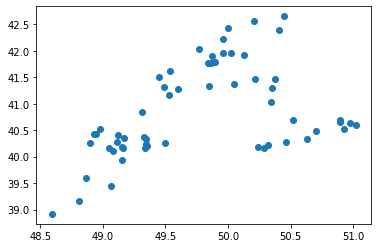

In [61]:
plt.scatter(x=state_stats_k['Biden_avg'].loc['2020-07':], y=state_stats_k['Trump_avg'].loc['2020-07':])

In [62]:
np.cov(state_stats_k[['Biden_avg', 'Trump_avg']].loc['2020-07':].T)

array([[0.43373396, 0.23463706],
       [0.23463706, 0.74178256]])

In [63]:
state_stats_k[['diff_avg', 'diff_std']].iloc[-1][1]

0.976

In [64]:
l = []

for i in range(1000):
    print('\r{}'.format(i), end='      ')
    l.append(np.random.normal(loc=state_stats_k[['diff_avg', 'diff_std']].iloc[-1][0],
                     scale=state_stats_k[['diff_avg', 'diff_std']].iloc[-1][1]))

999                                                                                                

(array([  4.,  21.,  63., 129., 211., 235., 195.,  97.,  43.,   2.]),
 array([ 6.07703013,  6.67868493,  7.28033973,  7.88199452,  8.48364932,
         9.08530411,  9.68695891, 10.28861371, 10.8902685 , 11.4919233 ,
        12.09357809]),
 <a list of 10 Patch objects>)

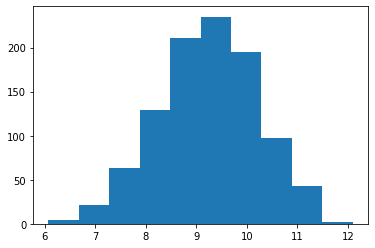

In [65]:
plt.hist(l)

---

---

---

# States report
## 2. how US states are leaned to vote?
---

In [66]:
Allstates_stats_k16 = get_Allstates_statsSmooth_atK(polls2020, candidates=['Biden', 'Trump'], k=16)

In [67]:
Allstates_diff_k16 = get_expected_electoral_college(k=16, election=2020, on_day=str(datetime.today().date()))

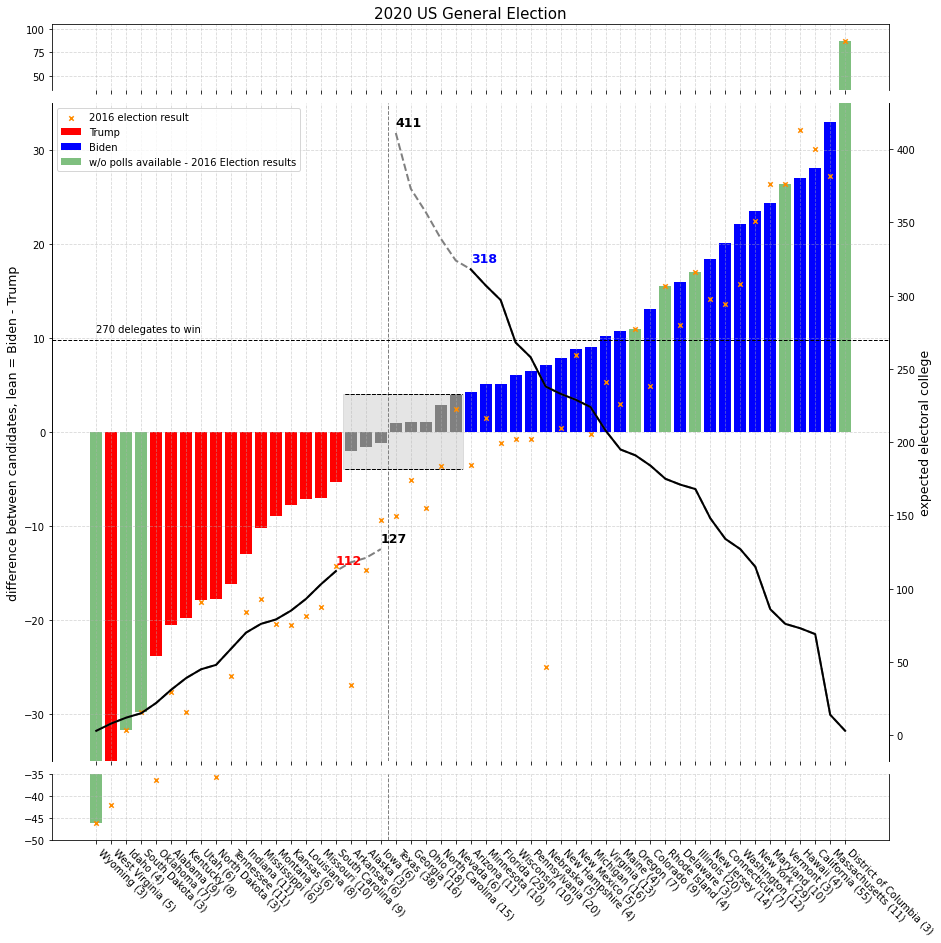

In [68]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15), sharex=True, 
                               gridspec_kw={'height_ratios': [0.5, 5, 0.5],  'hspace':0.05})
ax4 = ax2.twinx()


for a in [ax1, ax2, ax3]:
    a.scatter(x=Allstates_diff_k16.index, y=Allstates_diff_k16['diff_2016'], 
            color='darkorange', s=20., marker='x', zorder=5, label='2016 election result')
    a.bar(x=Allstates_diff_k16.loc[Allstates_diff_k16['lean'] == 'Trump', ['diff_avg']].index,
            height=Allstates_diff_k16.loc[Allstates_diff_k16['lean'] == 'Trump', ['diff_avg']].values.T[0], 
            color='red', label='Trump')
    a.bar(x=Allstates_diff_k16.loc[Allstates_diff_k16['lean'] == 'Biden', ['diff_avg']].index,
            height=Allstates_diff_k16.loc[Allstates_diff_k16['lean'] == 'Biden', ['diff_avg']].values.T[0], 
            color='blue', label='Biden')
    a.bar(x=Allstates_diff_k16.loc[Allstates_diff_k16['Biden_avg'].isna(), ['diff_avg']].index,
            height=Allstates_diff_k16.loc[Allstates_diff_k16['Biden_avg'].isna(), ['diff_avg']].values.T[0], 
            color='white')
    a.bar(x=Allstates_diff_k16.loc[Allstates_diff_k16['Biden_avg'].isna(), ['diff_avg']].index,
            height=Allstates_diff_k16.loc[Allstates_diff_k16['Biden_avg'].isna(), ['diff_avg']].values.T[0], 
            color='green', alpha=0.5, label='w/o polls available - 2016 Election results')

    a.bar(x=Allstates_diff_k16.loc[(Allstates_diff_k16['abs.diff_avg']<4), ['diff_avg']].index,
            height=Allstates_diff_k16.loc[(Allstates_diff_k16['abs.diff_avg']<4), ['diff_avg']].values.T[0], 
            color='gray')


    
ax4.plot(Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Trump'), ['expected_college_cumsum']], lw=2., ls='--', color='gray')
ax4.plot(Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Biden'), ['expected_college_cumsum']], lw=2., ls='--', color='gray')
ax4.plot(Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Trump')&(Allstates_diff_k16['diff_avg']<-4), ['expected_college_cumsum']], lw=2., color='black')
ax4.plot(Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Biden')&(Allstates_diff_k16['diff_avg']>4), ['expected_college_cumsum']], lw=2., color='black')

ax4.text(x=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Biden')&(Allstates_diff_k16['diff_avg']>4), ['expected_college_cumsum']].iloc[[0]].index, 
         y=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Biden')&(Allstates_diff_k16['diff_avg']>4), ['expected_college_cumsum']].iloc[[0]].values[0] + 5, 
         s=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Biden')&(Allstates_diff_k16['diff_avg']>4), ['expected_college_cumsum']].iloc[0].values[0], 
         fontsize=12.5, fontweight='bold', color='blue')
ax4.text(x=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Trump')&(Allstates_diff_k16['diff_avg']<-4), ['expected_college_cumsum']].iloc[[-1]].index, 
         y=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Trump')&(Allstates_diff_k16['diff_avg']<-4), ['expected_college_cumsum']].iloc[[-1]].values[0] + 5, 
         s=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Trump')&(Allstates_diff_k16['diff_avg']<-4), ['expected_college_cumsum']].iloc[-1].values[0], 
         fontsize=12.5, fontweight='bold', color='red')
ax4.text(x=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Biden'), ['expected_college_cumsum']].iloc[[0]].index, 
         y=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Biden'), ['expected_college_cumsum']].iloc[[0]].values[0] + 5, 
         s=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Biden'), ['expected_college_cumsum']].iloc[0].values[0], 
         fontsize=12.5, fontweight='bold')
ax4.text(x=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Trump'), ['expected_college_cumsum']].iloc[[-1]].index, 
         y=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Trump'), ['expected_college_cumsum']].iloc[[-1]].values[0] + 5, 
         s=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Trump'), ['expected_college_cumsum']].iloc[-1].values[0], 
         fontsize=12.5, fontweight='bold')


xmin = Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Trump')&(Allstates_diff_k16['abs.diff_avg']>4), ['expected_college_cumsum']].shape[0] - 0.5
xmax = 51 - Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Biden')&(Allstates_diff_k16['abs.diff_avg']>4), ['expected_college_cumsum']].shape[0] - 0.5

ax2.fill_between(x=np.arange(xmin, xmax+0.5, step=0.5), y1=-4, y2=4, color='gray', alpha=0.2, zorder=0)
ax2.axhline(y=4, xmin=(xmin+1)/50, xmax=(xmax)/50, color='black', ls='--', lw=1.)
ax2.axhline(y=-4, xmin=(xmin+1)/50, xmax=(xmax)/50, color='black', ls='--', lw=1.)

ax4.axhline(y=270, color='black', ls='--', lw=1.)
ax4.text(x=0, y=275,
         s='270 delegates to win')

ax1.set_ylim(35,105)
ax2.set_ylim(-35,35)
ax3.set_ylim(-50,-35)

axvline_sep = Allstates_diff_k16.loc[Allstates_diff_k16['lean']=='Trump'].shape[0]+(Allstates_diff_k16.loc[Allstates_diff_k16['lean']=='tie'].shape[0]/2)-0.5
ax2.axvline(axvline_sep, color='gray', ls='--', lw=1.)
ax3.axvline(axvline_sep, color='gray', ls='--', lw=1.)
ax2.axhline(y=4, xmin=(xmin+1)/50, xmax=(xmax)/50, color='black', ls='--', lw=1.)
ax2.axhline(y=-4, xmin=(xmin+1)/50, xmax=(xmax)/50, color='black', ls='--', lw=1.)


ax1.grid(which='both', axis='both', ls='--', alpha=0.5)
ax2.grid(which='both', axis='both', ls='--', alpha=0.5)
ax3.grid(which='both', axis='both', ls='--', alpha=0.5)

# Hide the right and top spines
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax2.legend()
ax3.set_xticklabels(Allstates_diff_k16.index, rotation=-45, ha='left')
ax1.set_title('2020 US General Election', fontsize=15)
ax2.set_ylabel('difference between candidates, lean = Biden - Trump', fontsize=12.5)
ax4.set_ylabel('expected electoral college', fontsize=12.5)
plt.show()

### Swing States
#### EX: Texas and Florida
---

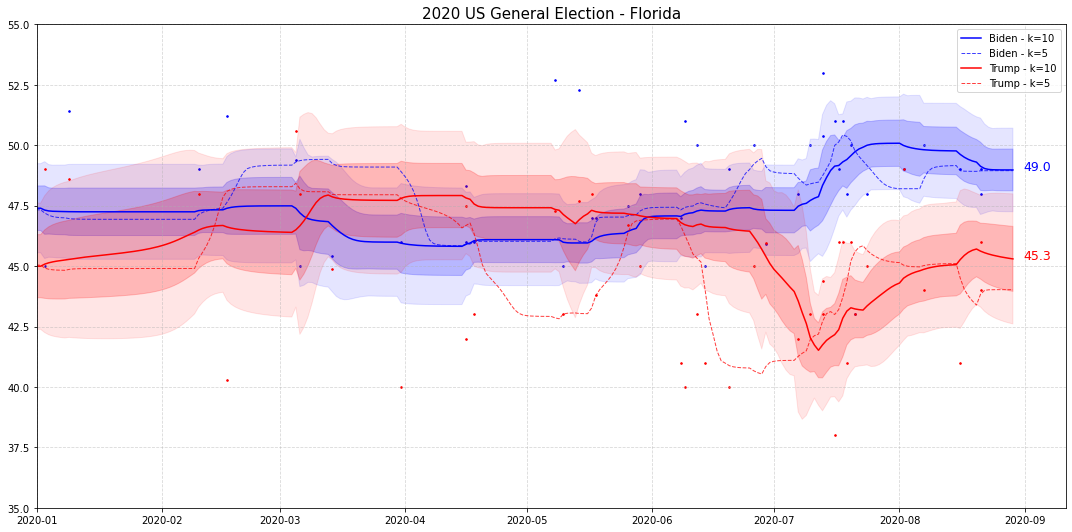

Biden  \
start_date end_date   pollster                     population sample_size          
2020-08-21 2020-08-23 Change Research              lv         1262          49.0   
           2020-08-22 Public Policy Polling        v          671           48.0   
2020-08-16 2020-08-16 Redfield & Wilton Strategies lv         1280          49.0   
2020-08-07 2020-08-09 Change Research              lv         469           50.0   
2020-08-02 2020-08-04 OnMessage Inc.               lv         400           49.0   

                                                                           Trump  
start_date end_date   pollster                     population sample_size         
2020-08-21 2020-08-23 Change Research              lv         1262          46.0  
           2020-08-22 Public Policy Polling        v          671           44.0  
2020-08-16 2020-08-16 Redfield & Wilton Strategies lv         1280          41.0  
2020-08-07 2020-08-09 Change Research              lv         469           44.0  
2020-08-02 2020-08-04 OnMessage Inc.               lv         400           49.0

In [69]:
get_polls_plot_atK(polls2020, 'Florida', 10, election=2020)
get_table_atK(polls2020, 'Florida', k=5)

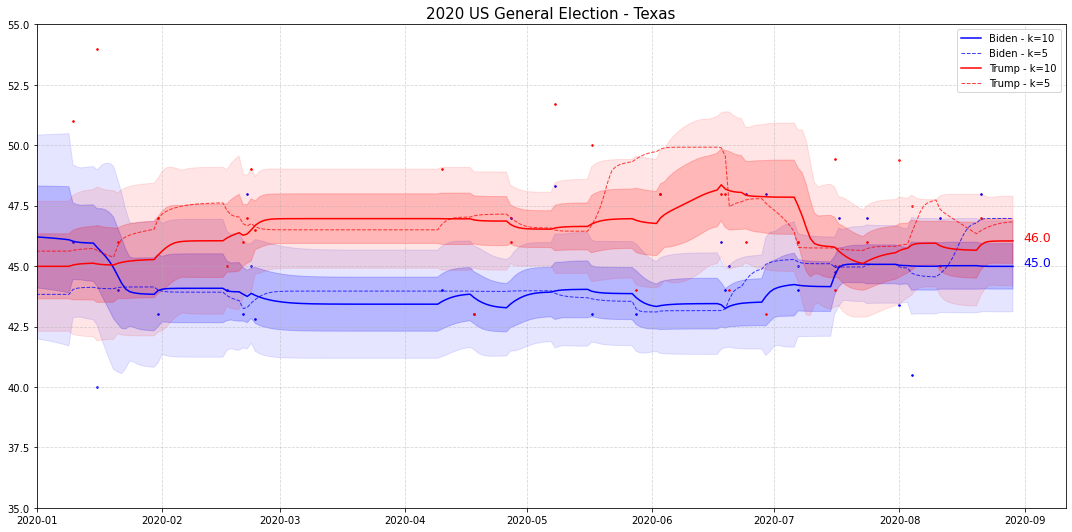

,,,,,Biden,Trump
start_date,end_date,pollster,population,sample_size,,
2020-08-21,2020-08-22,Public Policy Polling,v,764,48.0,47.0
2020-08-11,2020-08-13,Global Strategy Group,lv,700,47.0,45.0
2020-08-04,2020-08-13,YouGov,rv,846,40.5,47.5
2020-08-01,2020-08-05,Trafalgar Group,lv,1015,43.4,49.4
2020-07-24,2020-08-02,Morning Consult,lv,2576,47.0,46.0


In [70]:
get_polls_plot_atK(polls2020, 'Texas', 10, election=2020)
get_table_atK(polls2020, 'Texas', k=5)

---

---

---

# Trump Job Approval
## 3. how popular is the incumbent president?
---

In [71]:
pr_approval_polls2020 = pd.read_csv(path + '\data\processed\president_approval_polls2020.csv', 
                                    parse_dates=['start_date', 'end_date', 'created_at'], index_col=['start_date'])

In [72]:
pr_approval_polls2020.tail()

,question_id,poll_id,state,politician,pollster_id,pollster,sample_size,population,end_date,created_at,url,approve,disapprove,population_weight,weight,diff
start_date,,,,,,,,,,,,,,,,
2020-08-25,127824,68237,National,Trump,1562,Redfield & Wilton Strategies,2000,rv,2020-08-26,2020-08-28 10:07:00,https://redfieldandwiltonstrategies.com/latest...,41.7,44.93,0.9,1800.0,-3.23
2020-08-25,127829,68239,National,Trump,568,YouGov,785,rv,2020-08-27,2020-08-28 11:02:00,https://today.yougov.com/_pubapis/v5/us/tracke...,46.0,53.00,0.9,706.5,-7.00
2020-08-25,127812,68236,National,Trump,399,Rasmussen Reports/Pulse Opinion Research,1500,lv,2020-08-27,2020-08-28 09:25:00,http://www.rasmussenreports.com/public_content...,46.0,52.00,1.0,1500.0,-6.00
2020-08-26,127834,68242,National,Trump,568,YouGov,845,rv,2020-08-28,2020-08-28 17:47:00,https://today.yougov.com/_pubapis/v5/us/tracke...,39.0,60.00,0.9,760.5,-21.00
2020-08-27,127845,68246,National,Trump,568,YouGov,807,rv,2020-08-28,2020-08-29 13:28:00,https://docs.cdn.yougov.com/trcdohan8j/2020082...,43.0,54.00,0.9,726.3,-11.00


In [73]:
pr_approval_polls2020 = pr_approval_polls2020[pr_approval_polls2020['approve']+pr_approval_polls2020['disapprove'] < 100.]

In [74]:
national_pr_approval2020 = pr_approval_polls2020[pr_approval_polls2020['state'] == 'National']
national_pr_approval2020_k10 = get_state_statsSmooth_atK(pr_approval_polls2020, candidates=['approve', 'disapprove'], state='National', k=10)

In [75]:
national_pr_approval2020_k10

,approve_avg,disapprove_avg,diff_avg,approve_std,disapprove_std,diff_std
2017-01-20,45.0000,45.0000,0.0000,NaN,NaN,NaN
2017-01-21,44.9978,44.9702,-0.4316,1.1003,0.9966,1.8129
2017-01-22,45.0662,44.9388,-0.7071,1.2395,1.0232,2.3540
2017-01-23,44.4069,44.7558,-0.4787,1.3371,0.9860,1.6513
2017-01-24,44.1904,44.8066,-0.2608,0.8628,1.2789,1.2054
...,...,...,...,...,...,...
2020-08-25,44.4185,52.6051,-8.6290,1.6525,1.3680,2.2417
2020-08-26,44.7666,52.1440,-6.9731,1.7982,1.2693,2.3917
2020-08-27,44.6985,51.9047,-6.2696,1.7116,1.5445,1.9081
2020-08-28,44.6285,51.7755,-5.6764,1.7288,1.4993,1.7374


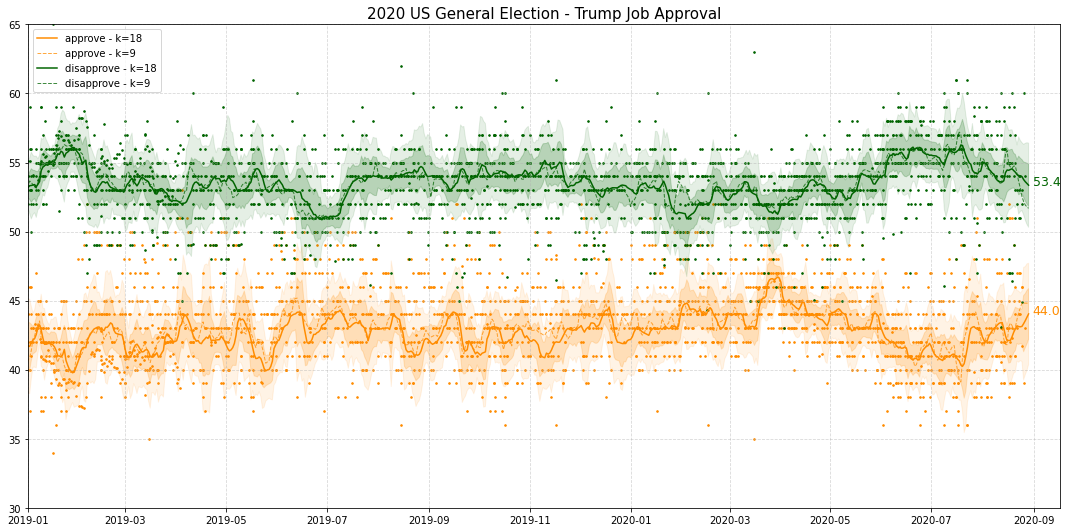

In [76]:
get_polls_plot_atK(pr_approval_polls2020, 'National', k=18, election='pr_approval')

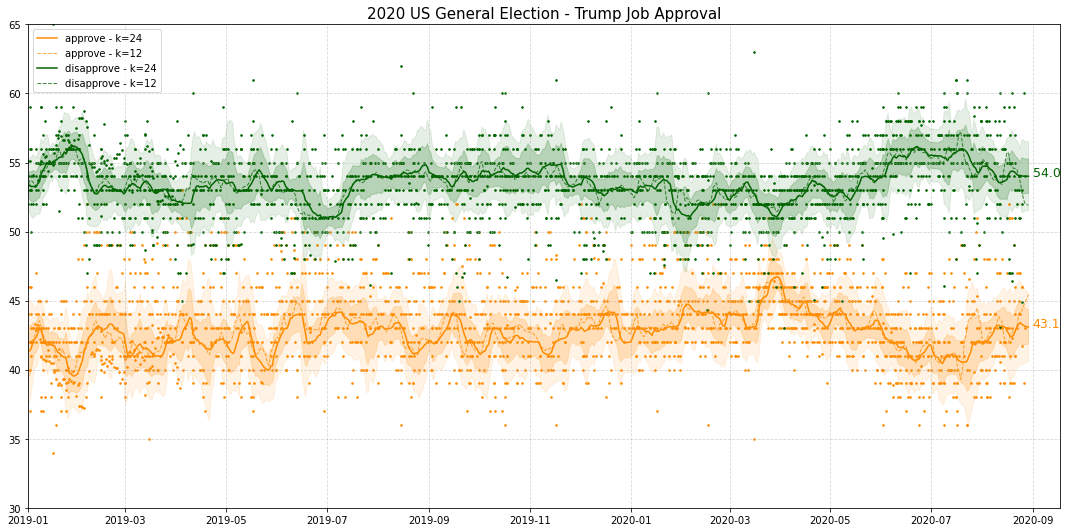

In [77]:
get_polls_plot_atK(pr_approval_polls2020, 'National', k=24, election='pr_approval')

---

---

---

# States: data visualization
---

In [78]:
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import matplotlib.pyplot as plt

import imageio
import glob

In [79]:
election_results = get_election_results()[['diff_2016', 'diff_2012', 'diff_2008']]

In [80]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

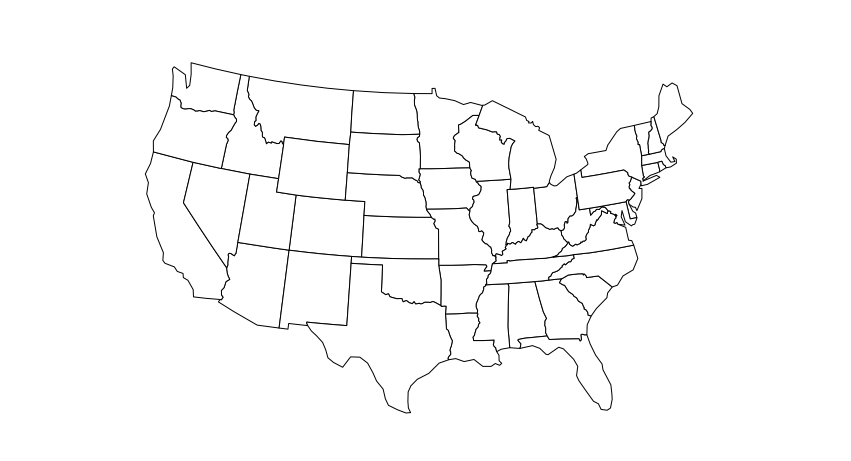

In [81]:
proj = gcrs.AlbersEqualArea()
gplt.polyplot(
    contiguous_usa,
    zorder=-1,
    linewidth=1,
    projection=proj,
    edgecolor='black',
    facecolor='white',
    figsize=(15, 15))


plt.savefig(path+'\\reports\\figures\\US States.png', bbox_inches='tight')
plt.show()

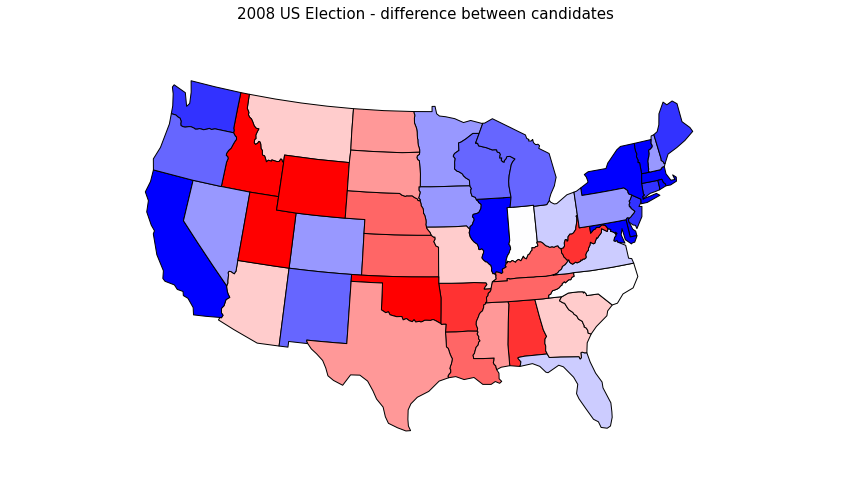

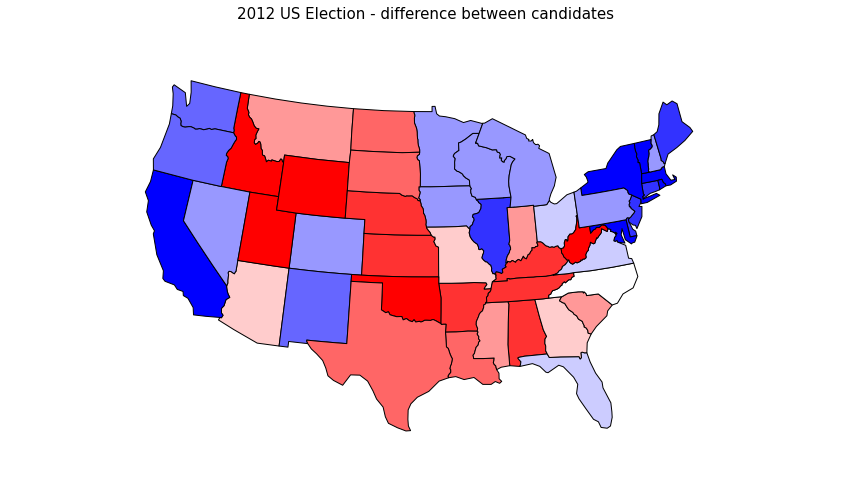

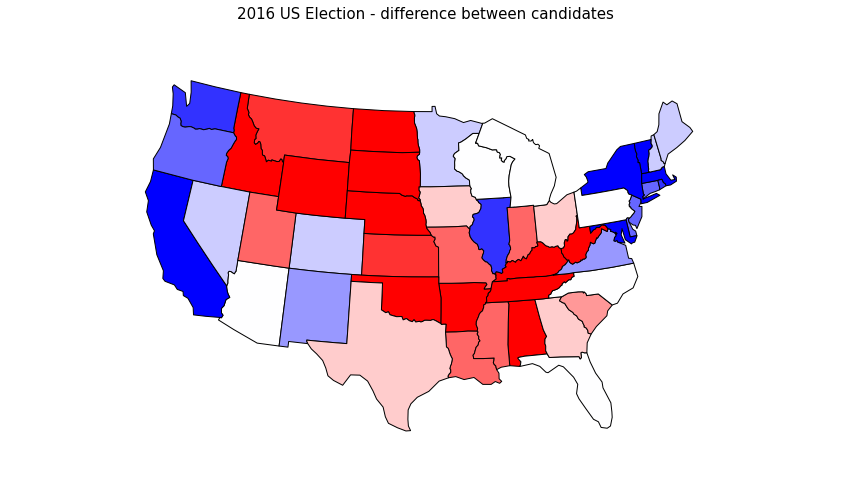

In [82]:
for year in ['2008', '2012', '2016']:
    proj = gcrs.AlbersEqualArea()
    scheme = mc.UserDefined(election_results['diff_'+year], bins=np.arange(-25, 25, 5))

    gplt.choropleth(contiguous_usa.set_index('state').join(election_results), hue='diff_'+year,
                    projection=proj, scheme=scheme,
                    edgecolor='black',
                    cmap='bwr_r', 
                    figsize=(15, 15))

    plt.title(year+' US Election - difference between candidates', fontsize=15)
    plt.savefig(path+'\\reports\\figures\\US States - diff_polls'+year+'.png', bbox_inches='tight')
    plt.show()

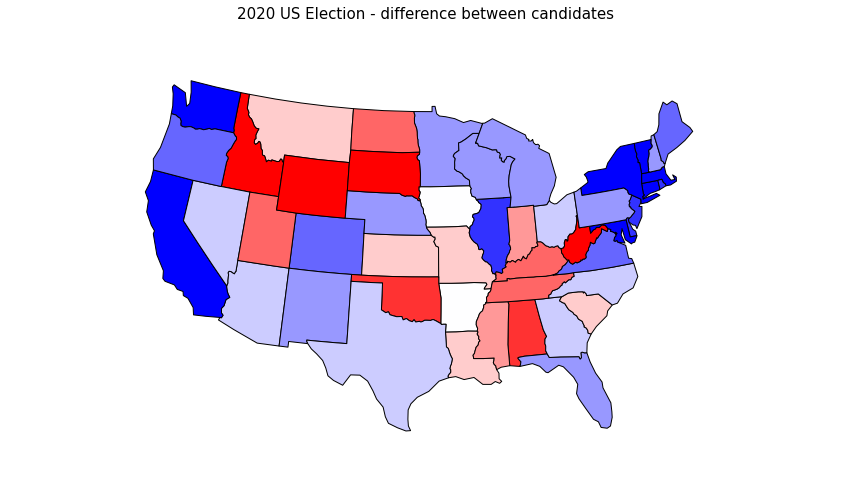

In [83]:
proj = gcrs.AlbersEqualArea()
scheme = mc.UserDefined(Allstates_diff_k16['diff_avg'], bins=np.arange(-25, 25, 5))

gplt.choropleth(contiguous_usa.set_index('state').merge(Allstates_diff_k16, on='state'), hue='diff_avg',
                projection=proj, scheme=scheme,
                edgecolor='black',
                cmap='bwr_r', 
                figsize=(15, 15))

plt.title('2020 US Election - difference between candidates', fontsize=15)
plt.savefig(path+'\\reports\\figures\\US States - diff_polls2020.png', bbox_inches='tight')
plt.show()

In [84]:
filenames = glob.glob(path+'\\reports\\figures\\US States - diff_polls*.png')


with imageio.get_writer(path+'\\reports\\figures\\US_movie.gif', mode='I', fps=0.75) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

---

---

---